In [ ]:
import os
import torch
import torch.nn as nn
import time
import pandas as pd
from torch.utils.data import DataLoader
import torch.nn.functional as func
from bs4 import BeautifulSoup
import numpy as np
from nltk.tokenize import word_tokenize
import string
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# position = torch.arange(0, 512, dtype=torch.float).unsqueeze(1)
# print(position.shape)
# position = torch.arange(0, 512, dtype=torch.float)
# print(position.shape)
!pip install sacrebleu



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

content = '/content/drive/My Drive/ssmt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_english = 'train_source.txt'
train_french = 'train_target_hindi.txt'

with open(os.path.join(content, train_english), "r") as file:
    train_english = file.readlines()

with open(os.path.join(content, train_french), "r") as file:
    train_french = file.readlines()

In [ ]:
test_english = 'test_source.txt'
test_french = 'test_target_hindi.txt'

with open(os.path.join(content, test_english), "r") as file:
    test_english = file.readlines()

with open(os.path.join(content, test_french), "r") as file:
    test_french = file.readlines()

In [ ]:
test_english[0], test_french[0]

('one one one\n', 'एक एक एक\n')

In [ ]:
punct = string.punctuation
punct.replace('.', '')

def get_lower(text):
    return text.lower()

def remove_punctuations(text):
    return ''.join([char for char in text if char not in punct])

def tokenize(text):
    # text = text.strip()
    return word_tokenize(text)

def remove_alpha_numeric(sentence):
    # return ' '.join(word for word in tokens if word.isalpha())
    words = sentence.split()
    alphabetic_words = [word for word in words if word.isalpha()]
    return ' '.join(alphabetic_words)

def remove_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

def remove_extra_gaps(text):
    return ' '.join(text.split())

def pipeline(text):
    text = get_lower(text)
    text = remove_punctuations(text)
    tokens = tokenize(text)
    text = remove_alpha_numeric(text)
    text = remove_tags(text)
    text = remove_extra_gaps(text)
    return text

In [ ]:
# test_english = [pipeline(text) for text in test_english]
# test_french = [pipeline(text) for text in test_french]

In [ ]:
# test_english[0]
# test_french[0]

In [ ]:
data = {}
maxi_english = 0
for sent in test_english:
    maxi_english = max(maxi_english, len(sent))
    if(len(sent) in data):
        data[len(sent)] += 1
    else:
        data[len(sent)] = 1

print(maxi_english)

41


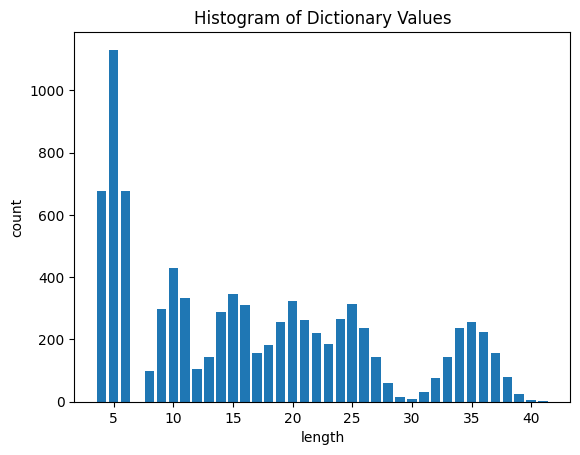

In [ ]:
import matplotlib.pyplot as plt


keys = data.keys()
values = data.values()

plt.bar(keys, values)

# Add labels and a title
plt.xlabel('length')
plt.ylabel('count')
plt.title('Histogram of Dictionary Values')

# Show the plot
plt.show()


In [ ]:
data = {}
maxi_french = 0
for sent in test_french:
    maxi_french = max(maxi_french, len(sent))
    if(len(sent) in data):
        data[len(sent)] += 1
    else:
        data[len(sent)] = 1

print(maxi_french)

37


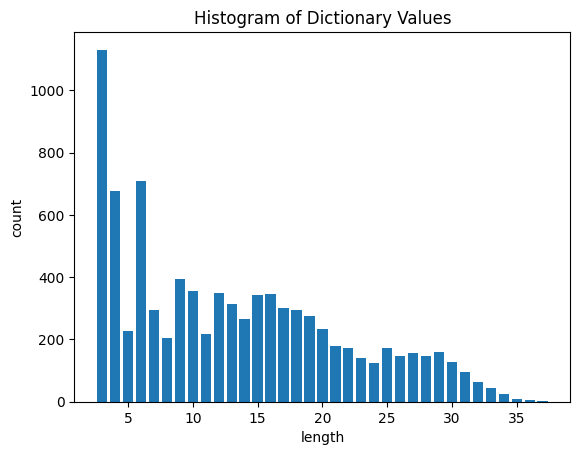

In [ ]:
import matplotlib.pyplot as plt


keys = data.keys()
values = data.values()

plt.bar(keys, values)

# Add labels and a title
plt.xlabel('length')
plt.ylabel('count')
plt.title('Histogram of Dictionary Values')

# Show the plot
plt.show()


In [ ]:
# df = pd.read_csv("Auguste_Maquet.txt", sep='', header=None, names="sentences")
df = pd.DataFrame({"english": test_english, "french": test_french})
print("Size : ", len(df))
df.head()

Size :  8700


english             french
0          one one one\n         एक एक एक\n
1  one three nine zero\n  एक तीन नौ शून्य\n
2        one five five\n     एक पांच पांच\n
3  one six eight eight\n      एक छः आठ आठ\n
4                  one\n               एक\n

In [ ]:
rows_to_drop = []
df['english'] = df['english'].str.lower()
df['french'] = df['french'].str.lower()
limit = 300  # For example, set your desired limit

for index, row in df.iterrows():
    if len(row['english']) > limit or len(row['french']) > limit:
        rows_to_drop.append(index)

df = df.drop(rows_to_drop)

print(df)

                    english                french
0             one one one\n            एक एक एक\n
1     one three nine zero\n     एक तीन नौ शून्य\n
2           one five five\n        एक पांच पांच\n
3     one six eight eight\n         एक छः आठ आठ\n
4                     one\n                  एक\n
...                     ...                   ...
8695     zero eight eight\n         शून्य आठ आठ\n
8696            zero nine\n            शून्य नौ\n
8697                 zero\n               शून्य\n
8698                 zero\n               शून्य\n
8699  zero zero seven one\n  शून्य शून्य सात एक\n

[8700 rows x 2 columns]


In [ ]:
m1, m2 = 0, 0
for index, row in df.iterrows():
    m1 = max(m1, len(row['english']))
    m2 = max(m2, len(row['french']))
print(m1, m2)

41 37


In [ ]:
word2idx_english = {'<PAD>': 0, '<UNK>': 1, '<EOS>' : 2, '<SOS>' : 3}
idx2word_english = {0 : '<PAD>', 1:'<UNK>', 2 : '<EOS>', 3 : '<SOS>'}
idx = 4
vocabulary_english = dict()
train_english = df['english']

for sent in train_english:
    for word in sent.split():
        if word not in vocabulary_english:
            vocabulary_english[word] = 1
        else:
            vocabulary_english[word] += 1

for word, val in vocabulary_english.items():
    if(val > 1) :
        word2idx_english[word] = idx
        idx2word_english[idx] = word
        idx += 1

vocab_size_english = len(idx2word_english)
vocab_size_english

14

In [ ]:
word2idx_french = {'<PAD>': 0, '<UNK>': 1, '<EOS>' : 2, '<SOS>' : 3}
idx2word_french = {0 : '<PAD>', 1:'<UNK>', 2 : '<EOS>', 3 : '<SOS>'}
idx = 4
vocabulary_french = dict()
train_french = df['french']

for sent in train_french:
    for word in sent.split():
        if word not in vocabulary_french:
            vocabulary_french[word] = 1
        else:
            vocabulary_french[word] += 1

for word, val in vocabulary_french.items():
    if(val > 1) :
        word2idx_french[word] = idx
        idx2word_french[idx] = word
        idx += 1

vocab_size_french = len(idx2word_french)
vocab_size_french

14

In [ ]:
# import gensim
# from gensim.models import Word2Vec
# model_dim = 512

# tokenized_sentences1 = [word_tokenize(sentence) for sentence in df['english']]
# tokenized_sentences2 = [word_tokenize(sentence) for sentence in df['french']]

# tokenized_sentences = tokenized_sentences1 + tokenized_sentences2
# # tokenized_sentences.extend(tokenized_sentences2)

# print(len(tokenized_sentences1), len(tokenized_sentences2), len(tokenized_sentences))

# print("len", len(tokenized_sentences))
# model_dim = 512
# word2vec_model = Word2Vec(tokenized_sentences, vector_size=model_dim, window=5, min_count=1, sg=0)

# # model.save("word2vec_model")
# # model = Word2Vec.load("your_word2vec_model")

# word_embedding = word2vec_model.wv['sample']

# # Check the dimension of the word embedding
# print(f"Embedding size of 'sample': {len(word_embedding)}")



In [ ]:
# len(tokenized_sentences1), len(tokenized_sentences2), len(tokenized_sentences)

In [ ]:
# word2vec_model.wv['que'], word2vec_model.wv['le']
import gensim
from gensim.models import Word2Vec
model_dim = 512

tokenized_sentences1 = [word_tokenize(sentence) for sentence in df['english']]
tokenized_sentences2 = [word_tokenize(sentence) for sentence in df['french']]

tokenized_sentences = tokenized_sentences1 + tokenized_sentences2
# tokenized_sentences.extend(tokenized_sentences2)

word2vec_model = Word2Vec(tokenized_sentences, vector_size=model_dim, window=5, min_count=1, sg=0)
word2vec_model = word2vec_model.wv

In [ ]:
# tokenized_sentences[:5]

In [ ]:
# unk_vector = np.ones(model_dim)
# pad_vector = np.zeros(model_dim)
# sos_vector = np.random.rand(model_dim)
# eos_vector = np.random.rand(model_dim)

# embedding_vector = {'<PAD>':unk_vector, '<SOS>':sos_vector, '<UNK>':unk_vector, '<EOS>':eos_vector}

# def get_word_embedding(word):
#     if word in word2vec_model:
#         return word2vec_model[word]
#     elif word in embedding_vector:
#         return embedding_vector[word]
#     else:
#         return unk_vector


# embedding_matrix_english = []
# for word, _ in word2idx_english.items():
#     # print(word)
#     embedding_matrix_english.append(get_word_embedding(word))

# embedding_matrix_english = torch.tensor(embedding_matrix_english, dtype=torch.float32)
# np.array(embedding_matrix_english).shape


In [ ]:
# unk_vector = np.ones(model_dim)
# pad_vector = np.zeros(model_dim)
# sos_vector = np.random.rand(model_dim)
# eos_vector = np.random.rand(model_dim)

# embedding_vector = {'<PAD>':unk_vector, '<SOS>':sos_vector, '<UNK>':unk_vector, '<EOS>':eos_vector}

# def get_word_embedding(word):
#     if word in word2vec_model:
#         return word2vec_model[word]
#     elif word in embedding_vector:
#         return embedding_vector[word]
#     else:
#         return unk_vector


# embedding_matrix_french = []
# for word, _ in word2idx_french.items():
#     # print(word)
#     embedding_matrix_french.append(get_word_embedding(word))

# embedding_matrix_french = torch.tensor(embedding_matrix_french, dtype=torch.float32)
# np.array(embedding_matrix_french).shape


In [ ]:
word2idx_english['<SOS>']

3

In [ ]:


import torch
from torch.utils.data import Dataset, DataLoader

# # Define your custom dataset class
# class CustomDataset(Dataset):
#     def __init__(self, english, french, word2idx_english, word2idx_french, max_length):
#         self.english = english
#         self.french = french
#         self.word2idx_english = word2idx_english
#         self.word2idx_french = word2idx_french
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.english)

#     def __getitem__(self, idx):
#         english, french = self.english[idx], self.french[idx]
#         # print(english)
#         # print(french)
#         sos_token = [self.word2idx_english['<SOS>']]
#         sentence_tokens = [self.word2idx_english[word] if word in self.word2idx_english else self.word2idx_english['<UNK>'] for word in english]
#         eos_token = [self.word2idx_english['<EOS>']]
#         pad_tokens = [self.word2idx_english['<PAD>']] * (self.max_length - len(sentence_tokens))
#         padded_english = sos_token + sentence_tokens + eos_token + pad_tokens

#         mask_eng = [1]*(len(sentence_tokens) + 1)
#         mask_eng.extend([1])
#         mask_eng.extend([0]*(len(pad_tokens)))

#         sos_token = [self.word2idx_french['<SOS>']]
#         sentence_tokens = [self.word2idx_french[word] if word in self.word2idx_french else self.word2idx_french['<UNK>'] for word in french]
#         eos_token = [self.word2idx_french['<EOS>']]
#         pad_tokens = [self.word2idx_french['<PAD>']] * (self.max_length - len(sentence_tokens))
#         padded_french = sos_token + sentence_tokens + eos_token + pad_tokens

#         mask_fr = [1]*(len(sentence_tokens) + 1)
#         mask_fr.extend([1])
#         mask_fr.extend([0]*(len(pad_tokens)))

#         return torch.tensor(padded_english).to(torch.int64), torch.tensor(padded_french).to(torch.int64), torch.tensor(mask_eng).to(torch.int64), torch.tensor(mask_fr).to(torch.int64)


class CustomTranslationDataset(Dataset):
    def __init__(self, english_data, french_data, word2idx_english, word2idx_french, max_length):
        self.english_data = english_data
        self.french_data = french_data
        self.word2idx_english = word2idx_english
        self.word2idx_french = word2idx_french
        self.max_length = max_length

    def __len__(self):
        return len(self.english_data)

    def __getitem__(self, idx):
        english_sentence = self.english_data[idx]
        french_sentence = self.french_data[idx]

        # Convert lists of words to strings
        english_sentence = ' '.join(english_sentence)
        french_sentence = ' '.join(french_sentence)

        # Process English sentence
        english_tokens = [self.word2idx_english.get(word, self.word2idx_english['<UNK>']) for word in english_sentence.split()]
        english_length = min(len(english_tokens), self.max_length)
        english_padding = [self.word2idx_english['<PAD>']] * (self.max_length - english_length)
        english_tokens = english_tokens[:self.max_length] + english_padding
        mask_eng = [1] * english_length + [0] * (self.max_length - english_length)

        # Process French sentence
        french_tokens = [self.word2idx_french.get(word, self.word2idx_french['<UNK>']) for word in french_sentence.split()]
        french_length = min(len(french_tokens), self.max_length)
        french_padding = [self.word2idx_french['<PAD>']] * (self.max_length - french_length)
        french_tokens = french_tokens[:self.max_length] + french_padding
        mask_fr = [1] * french_length + [0] * (self.max_length - french_length)

        return torch.tensor(english_tokens), torch.tensor(french_tokens), torch.tensor(mask_eng), torch.tensor(mask_fr)


In [ ]:
mask_eng = [1]*(2 + 1)
mask_eng.extend([0]*(3))
mask_eng.extend([1])
mask_eng

[1, 1, 1, 0, 0, 0, 1]

In [ ]:
custom_dataset = CustomTranslationDataset(tokenized_sentences1, tokenized_sentences2, word2idx_english, word2idx_french, 302)

# Create a DataLoader using your custom dataset
batch_size = 16
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
len(df), len(dataloader), len(df)/batch_size


(8700, 544, 543.75)

In [ ]:
for a, b, c, d in dataloader:
    print(a, a.shape)
    print(b, b.shape)
    print(c, c.shape)
    print(d, d.shape)
    break

tensor([[ 5,  0,  0,  ...,  0,  0,  0],
        [13, 13,  7,  ...,  0,  0,  0],
        [13,  5,  5,  ...,  0,  0,  0],
        ...,
        [ 6,  8, 13,  ...,  0,  0,  0],
        [ 6,  0,  0,  ...,  0,  0,  0],
        [ 8,  0,  0,  ...,  0,  0,  0]]) torch.Size([16, 302])
tensor([[ 5,  0,  0,  ...,  0,  0,  0],
        [13, 13,  7,  ...,  0,  0,  0],
        [13,  5,  5,  ...,  0,  0,  0],
        ...,
        [ 6,  8, 13,  ...,  0,  0,  0],
        [ 6,  0,  0,  ...,  0,  0,  0],
        [ 8,  0,  0,  ...,  0,  0,  0]]) torch.Size([16, 302])
tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]]) torch.Size([16, 302])
tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm

# Download the pre-trained MarianMT model and tokenizer for English to Hindi translation
model_name = "Helsinki-NLP/opus-mt-en-hi"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage d

In [ ]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 5

# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)


In [ ]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    total_loss = 0

    for (batch_input_embeddings, batch_target_embeddings, mask_eng, mask_fr) in dataloader:
        batch_input_embeddings = batch_input_embeddings.to(device)
        batch_target_embeddings = batch_target_embeddings.to(device)
        mask_eng = mask_eng.to(device)

        optimizer.zero_grad()
        mask = (mask_eng != 0).unsqueeze(1).unsqueeze(2)

        # Forward pass using the pre-trained MarianMT model
        outputs = model(input_ids=batch_input_embeddings, decoder_input_ids=batch_target_embeddings, labels=batch_target_embeddings)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}')

 20%|██        | 1/5 [07:14<28:59, 434.77s/it]

Epoch [1/5], Loss: 0.21723014007404665


 40%|████      | 2/5 [14:33<21:51, 437.33s/it]

Epoch [2/5], Loss: 0.08883224120226633


 60%|██████    | 3/5 [21:53<14:36, 438.26s/it]

Epoch [3/5], Loss: 0.08740240459412556


 80%|████████  | 4/5 [29:10<07:17, 437.75s/it]

Epoch [4/5], Loss: 0.08592337899950936


100%|██████████| 5/5 [36:27<00:00, 437.57s/it]

Epoch [5/5], Loss: 0.08581700790262617


In [ ]:

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the transformer_encoder: {total_params}")

Total parameters in the transformer_encoder: 76381184


In [ ]:
# checkpoint = {
#         'epoch': epoch + 1,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': avg_loss
#     }
# torch.save(checkpoint, content + '/ssmt_model.pth')

In [ ]:


# Load the checkpoint
checkpoint_path = content + '/ssmt_model.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load the model state
model.load_state_dict(checkpoint['model_state_dict'])

# Optionally, load the optimizer state if you want to continue training
optimizer = torch.optim.Adam(model.parameters())  # Adjust the optimizer type accordingly
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Get other checkpoint information
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(f'Model loaded. Last trained epoch: {epoch}, Last training loss: {loss}')


Model loaded. Last trained epoch: 5, Last training loss: 0.08581700790262617


In [ ]:
# path = "/content/drive/My Drive/ssmt_model_1.pth"
# torch.save(model.state_dict(), path)

In [ ]:
model_1 = model.to("cpu")
device = "cpu"

In [ ]:
def convert_to_sentences(tokenized_sentences, idx2word):
    sentences = []
    for sentence in tokenized_sentences:
        words = [idx2word[idx] for idx in sentence if idx in idx2word]
        sentence_str = ' '.join(words)
        sentences.append(sentence_str)
    return sentences


In [2]:
from nltk.translate.bleu_score import sentence_bleu

# Evaluation loop
targets = []
dtranslated = []
eng = []
count = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for (batch_input_embeddings, batch_target_embeddings, mask_eng, mask_fr) in dataloader:
        batch_input_embeddings = batch_input_embeddings.to(device)
        batch_target_embeddings = batch_target_embeddings.to(device)
        mask_eng = mask_eng.to(device)

        mask = (mask_eng != 0).unsqueeze(1).unsqueeze(2)

        # Forward pass without optimization
        outputs = model(input_ids=batch_input_embeddings, decoder_input_ids=batch_target_embeddings, labels=batch_target_embeddings)
        logits = outputs.logits

        # Generate translations
        translations = model.generate(input_ids=batch_input_embeddings, max_length=41)

        # Convert tensor to list of sentences
        targets.extend(batch_target_embeddings.cpu().numpy())
        dtranslated.extend(translations.cpu().numpy())
        eng.extend(batch_input_embeddings.cpu().numpy())
        if(count > 10):
            break
        count += 1
# Convert targets and translations to human-readable sentences
targets_sentences = convert_to_sentences(targets, idx2word_french)
dtranslated_sentences = convert_to_sentences(dtranslated, idx2word_french)
engs = convert_to_sentences(eng, idx2word_english)
# Calculate BLEU score
bleu_scores = [sentence_bleu([t], dt) for t, dt in zip(targets_sentences, dtranslated_sentences)]
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)

print(f'Average BLEU Score on Training Dataset: {avg_bleu_score}')


Average BLEU Score on Training Dataset: 1


In [ ]:
eng_sentences_no_pad = [sentence.replace(' <PAD>', '') for sentence in engs]

print(eng_sentences_no_pad)


['four four five', 'one', 'three', 'four five eight', 'three three eight', 'six four four zero four', 'one five zero three six', 'zero nine zero nine', 'two five two', 'six zero six one zero five seven', 'eight one four five two', 'one nine five six six eight seven', 'seven', 'two five one two', 'five two three nine', 'three six zero zero two', 'eight seven seven four', 'eight', 'two one eight', 'eight zero', 'nine two two six zero one three', 'five', 'zero', 'two two five', 'five nine one zero five zero seven', 'six four', 'six four nine four zero', 'two', 'six three', 'three eight nine two two three one', 'eight eight', 'six nine eight eight five five nine', 'three one five nine', 'two one four zero three', 'nine two five four four', 'seven', 'two', 'zero', 'eight three three', 'four zero six seven two', 'eight one six zero', 'eight', 'seven one seven six one seven one', 'nine eight', 'nine six', 'six', 'two two', 'eight', 'zero seven one', 'zero four four', 'nine five six seven seve

In [ ]:

# target_sentences_no_pad = [sentence.replace(' <PAD>', '') for sentence in targets_sentences]

# print(target_sentences_no_pad)

targets_sentences


['चार चार पांच', 'एक', 'तीन', 'चार पांच आठ', 'तीन तीन आठ', 'छः चार चार शून्य चार', 'एक पांच शून्य तीन छः', 'शून्य नौ शून्य नौ', 'दो पांच दो', 'छः शून्य छः एक शून्य पांच सात', 'आठ एक चार पांच दो', 'एक नौ पांच छः छः आठ सात', 'सात', 'दो पांच एक दो', 'पांच दो तीन नौ', 'तीन छः शून्य शून्य दो', 'आठ सात सात चार', 'आठ', 'दो एक आठ', 'आठ शून्य', 'नौ दो दो छः शून्य एक तीन', 'पांच', 'शून्य', 'दो दो पांच', 'पांच नौ एक शून्य पांच शून्य सात', 'छः चार', 'छः चार नौ चार शून्य', 'दो', 'छः तीन', 'तीन आठ नौ दो दो तीन एक', 'आठ आठ', 'छः नौ आठ आठ पांच पांच नौ', 'तीन एक पांच नौ', 'दो एक चार शून्य तीन', 'नौ दो पांच चार चार', 'सात', 'दो', 'शून्य', 'आठ तीन तीन', 'चार शून्य छः सात दो', 'आठ एक छः शून्य', 'आठ', 'सात एक सात छः एक सात एक', 'नौ आठ', 'नौ छः', 'छः', 'दो दो', 'आठ', 'शून्य सात एक', 'शून्य चार चार', 'नौ पांच छः सात सात शून्य एक', 'दो तीन तीन आठ सात एक दो', 'एक', 'एक शून्य छः', 'छः नौ छः पांच शून्य', 'छः', 'शून्य चार', 'चार सात चार', 'एक तीन आठ', 'शून्य आठ शून्य दो सात शून्य पांच', 'चार दो', 'चार दो सात तीन 

CONVERT TEXT TO VOICE

In [ ]:
! pip install gTTS -q

In [ ]:
from gtts import gTTS
import os

def text_to_speech(text, language='en', save_path='output.mp3'):
    tts = gTTS(text=text, lang=language, slow=False)
    tts.save(save_path)

    os.system(f"start {save_path}")




In [ ]:
text_to_speech("छः शून्य नौ दो शून्य शून्य चार", language='hi', save_path='output.mp3')